In [1]:
%load_ext autoreload
%autoreload 2

In [45]:
import os
import sys
import copy
from typing import (
    Dict, 
    List,
    Any
)

import mlflow
from datetime import datetime


import numpy as np
import pandas as pd

from scipy.stats import randint, uniform
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedShuffleSplit

import shap

from joblib import load, dump

import seaborn as sns
import matplotlib.pyplot as plt

In [49]:
sys.path.append(os.path.join(os.getcwd(), '..'))
from utils.metrics import Metrics
from utils.modelling_tools import (
    search_hyper_params_and_log,
    evaluate_model, 
    update_solver_by_penalty
)
from utils.metrics_by_quantile import MetricsByQuantile

In [4]:
RUN_NAME: str = '04-RF-hyperparams_tunning'

In [5]:
PROJECT_PATH: str = os.path.join(os.getcwd(), '..')
DATA_PATH: str = os.path.join(PROJECT_PATH, 'data')
OPT_BIN_PATH: str = os.path.join(os.path.join(PROJECT_PATH, 'objects'), 'optbinners')
MODELS_PATH: str = os.path.join(os.path.join(PROJECT_PATH, 'objects'), 'models')

In [6]:
TRAIN_FROM: datetime.date = pd.to_datetime('2021-12-01').date()
TRAIN_TO: datetime.date = pd.to_datetime('2022-01-01').date()

VAL_FROM: datetime.date = pd.to_datetime('2022-01-01').date()
VAL_TO: datetime.date = pd.to_datetime('2022-05-01').date()

TEST_FROM: datetime.date = pd.to_datetime('2022-05-01').date()
TEST_TO: datetime.date = pd.to_datetime('2022-08-01').date()

In [7]:
# set constants
COLS_TO_USE: List[str] = [
"OPTIN_11SCN_MLOptBin",
"G5_ND_SPECIIOptBin",
"Marital_StatusOptBin",
"SP_F2_33OptBin",
"AFF_B_09_01OptBin",
"TRD_A_20OptBin",
"TRD_A_08OptBin",
"VM01_SP_VM2_15OptBin",
"GEN11_SP_N_92OptBin",
"SP_EDI_24OptBin",
"SP_G_37OptBin",
"E4_Q_17OptBin",
"TRD_C_07OptBin",
"TRD_B_20OptBin",
"SP_B2_18OptBin",
"SPA_F2_33OptBin",
"VM01_SP_VM2_14OptBin",
"VM01_SP_VM2_24OptBin",
"SP_G_38OptBin",
"TRD_O_05OptBin",
"E1_A_09OptBin",
"TRD_O_07OptBin",
"ND_INC_03OptBin",
"VM01_SP_VM2_17OptBin",
"SP_B1_14OptBin",
"GEN11_SP_N_91OptBin",
"GEN11_SP_EDI_07OptBin",
"ND_ECC_06OptBin",
"TRD_B_18OptBin",
"EA5_S_01OptBin",
"SP_I_67_01OptBin",
"SP_I_63_01OptBin",
"SP_B2_20OptBin",
"E4_Q_04OptBin",
"ND_ECC_04OptBin",
"VAL_DELINQ_ACCSOptBin",
"EA1_D_02OptBin",
"AFF_E_07_01OptBin",
"TRD_O_06OptBin",
"AFF_T_07_01OptBin",
]

In [8]:
TARGET_NAME: str = 'GB6_Flag_2Limit'
TARGET_VALS: List[int] = [0, 1]
TARGET_BIN: str = f'_{TARGET_NAME}_bin'

PALETTE: Dict[str, str] = {
    TARGET_NAME: {
        'G': 'green',
        'B': 'red',
        'I': 'black'
    },
    TARGET_BIN: {0: 'green', 1: 'red'},
    'DataPart': {'Train+Val': 'black', 'Val': 'blue', 'Test': 'red', 'Train': 'orange'}
}

In [9]:
N_ITER: int = 100
RANDOM_SEED: int = 42
CONFIDENCE_LEVEL = 0.05

In [10]:
MODEL = RandomForestClassifier

In [11]:
PARAMS: Dict[str, Any] = dict(
    n_estimators=randint(100, 1000), 
    max_depth=[1, 2, 3], 
    min_samples_split=randint(50, 100),
    n_jobs=[-1],
    random_state=[RANDOM_SEED], 
    class_weight=['balanced', 'balanced_subsample'] 
)

In [12]:
# read data
df: pd.DataFrame = pd.read_csv(os.path.join(DATA_PATH, 'final_aiq2_optbins.csv'), low_memory=False)

In [13]:
print('Number of rows: %.0f; columns: %.0f' % df.shape)

Number of rows: 110462; columns: 2069


# Preprocessing

Convert dates to the corresponding types

In [14]:
for col in ['_RDATE_EOM', '_RDATE']:
    df[col] = pd.to_datetime(df[col]).dt.date

In [15]:
print('Available date range:')
df['_RDATE'].agg(['min', 'max'])

Available date range:


min    2021-06-30
max    2023-11-30
Name: _RDATE, dtype: object

# Split data

In [16]:
df_train = df.loc[
    (df._RDATE >= TRAIN_FROM) &
    (df._RDATE < TRAIN_TO) & 
    (df[TARGET_NAME] != 'I'),
    COLS_TO_USE + [TARGET_NAME, TARGET_BIN, '_RDATE']
].reset_index(drop=True)

df_train_val = df.loc[
    (df._RDATE >= TRAIN_FROM) &
    (df._RDATE < VAL_TO) &
    (df[TARGET_NAME] != 'I'),
    COLS_TO_USE + [TARGET_NAME, TARGET_BIN, '_RDATE']
].reset_index(drop=True)

df_val = df.loc[
    (df._RDATE >= VAL_FROM) &
    (df._RDATE < VAL_TO) &
    (df[TARGET_NAME] != 'I'),
    COLS_TO_USE + [TARGET_NAME, TARGET_BIN, '_RDATE']
].reset_index(drop=True)

df_test_same = df.loc[
    (df._RDATE >= TEST_FROM) &
    (df._RDATE < TEST_TO) &
    (df[TARGET_NAME] != 'I'),
    COLS_TO_USE + [TARGET_NAME, TARGET_BIN, '_RDATE']
].reset_index(drop=True)

df_test = df.loc[
    (df._RDATE >= TEST_FROM) &
    (df._RDATE < TEST_TO),
    COLS_TO_USE + [TARGET_NAME, TARGET_BIN, '_RDATE']
].reset_index(drop=True)

In [17]:
data_dict = {
    "df_train": df_train,
    "df_val": df_val,
    "df_train_val": df_train_val, 
    "df_test_same": df_test_same,
    "df_test": df_test
}

In [18]:
# randomly select N observations from test data
N = 10000
sss = StratifiedShuffleSplit(n_splits=1, train_size=N, random_state=RANDOM_SEED)
indx = sss.split(data_dict['df_test_same'].reset_index(drop=True), data_dict['df_test_same'][TARGET_BIN])
random_indx = list(indx)[0][0]

assert len(random_indx) == N, "Incorrect number of elements in the subsample"
test_sample = data_dict['df_test_same'].reset_index(drop=True).iloc[random_indx, :].reset_index(drop=True)

In [19]:
data_dict['df_test_same_sample'] = test_sample

# Run the experiment

## Feature selection with RF

In [20]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000/")
mlflow.set_experiment("[Experian][RF-feature-selection]")

<Experiment: artifact_location='mlflow-artifacts:/144656820801520540', creation_time=1716879635678, experiment_id='144656820801520540', last_update_time=1716879635678, lifecycle_stage='active', name='[Experian][RF-feature-selection]', tags={}>

In [21]:
experiment_description = f"""
    'features': {len(COLS_TO_USE)},
    'target': {TARGET_BIN},
    'target_vals': '0==G, 1==B',
    'model': {MODEL.__name__},
    'data_version': '22.05.2024', 
    'train_period': [{TRAIN_FROM.strftime('%Y-%m-%d') + ', ' + TRAIN_TO.strftime('%Y-%m-%d')}),
    'val_period': [{VAL_FROM.strftime('%Y-%m-%d') + ', ' + VAL_TO.strftime('%Y-%m-%d')}),
    'test_period': [{TEST_FROM.strftime('%Y-%m-%d') + ', ' + TEST_TO.strftime('%Y-%m-%d')}),
"""

In [22]:
print(experiment_description)


    'features': 40,
    'target': _GB6_Flag_2Limit_bin,
    'target_vals': '0==G, 1==B',
    'model': RandomForestClassifier,
    'data_version': '22.05.2024', 
    'train_period': [2021-12-01, 2022-01-01),
    'val_period': [2022-01-01, 2022-05-01),
    'test_period': [2022-05-01, 2022-08-01),



2024/05/30 12:55:21 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:55:21 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 1 / 100


2024/05/30 12:55:22 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 12:55:22 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 2 / 100


2024/05/30 12:55:36 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:55:36 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 3 / 100


2024/05/30 12:55:43 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 12:55:43 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 4 / 100


2024/05/30 12:55:53 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:55:53 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 5 / 100


2024/05/30 12:56:02 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:56:02 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 6 / 100


2024/05/30 12:56:14 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:56:14 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 7 / 100


2024/05/30 12:56:23 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:56:23 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 8 / 100


2024/05/30 12:56:32 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:56:32 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 9 / 100


2024/05/30 12:56:42 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:56:42 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 10 / 100


2024/05/30 12:56:52 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 12:56:52 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 11 / 100


2024/05/30 12:57:01 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:57:01 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 12 / 100


2024/05/30 12:57:11 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:57:11 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 13 / 100


2024/05/30 12:57:20 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:57:20 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 14 / 100


2024/05/30 12:57:29 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:57:29 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 15 / 100


2024/05/30 12:57:41 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 12:57:41 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 16 / 100


2024/05/30 12:57:49 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:57:49 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 17 / 100


2024/05/30 12:58:01 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:58:01 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 18 / 100


2024/05/30 12:58:10 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:58:10 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 19 / 100


2024/05/30 12:58:18 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:58:18 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 20 / 100


2024/05/30 12:58:27 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:58:27 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 21 / 100


2024/05/30 12:58:38 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:58:38 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 22 / 100


2024/05/30 12:58:47 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:58:47 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 23 / 100


2024/05/30 12:59:00 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 12:59:00 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 24 / 100


2024/05/30 12:59:11 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:59:11 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 25 / 100


2024/05/30 12:59:22 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:59:22 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 26 / 100


2024/05/30 12:59:32 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:59:32 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 27 / 100


2024/05/30 12:59:42 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:59:42 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 28 / 100


2024/05/30 12:59:51 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 12:59:51 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 29 / 100


2024/05/30 13:00:02 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:00:02 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 30 / 100


2024/05/30 13:00:13 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:00:13 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 31 / 100


2024/05/30 13:00:24 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:00:24 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 32 / 100


2024/05/30 13:00:35 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:00:35 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 33 / 100


2024/05/30 13:00:44 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:00:44 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 34 / 100


2024/05/30 13:00:57 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 13:00:57 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 35 / 100


2024/05/30 13:01:07 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:01:07 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 36 / 100


2024/05/30 13:01:16 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:01:16 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 37 / 100


2024/05/30 13:01:29 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 13:01:29 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 38 / 100


2024/05/30 13:01:40 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 13:01:40 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 39 / 100


2024/05/30 13:01:49 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 13:01:49 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 40 / 100


2024/05/30 13:02:00 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:02:00 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 41 / 100


2024/05/30 13:02:11 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:02:11 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 42 / 100


2024/05/30 13:02:21 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:02:21 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 43 / 100


2024/05/30 13:02:30 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 13:02:30 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 44 / 100


2024/05/30 13:02:39 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 13:02:39 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 45 / 100


2024/05/30 13:02:49 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 13:02:49 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 46 / 100


2024/05/30 13:03:00 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:03:00 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 47 / 100


2024/05/30 13:03:10 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:03:10 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 48 / 100


2024/05/30 13:03:21 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:03:21 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 49 / 100


2024/05/30 13:03:30 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:03:30 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 50 / 100


2024/05/30 13:03:38 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:03:38 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 51 / 100


2024/05/30 13:03:46 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:03:46 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 52 / 100


2024/05/30 13:03:55 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:03:55 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 53 / 100


2024/05/30 13:04:03 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:04:03 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 54 / 100


2024/05/30 13:04:14 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:04:14 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 55 / 100


2024/05/30 13:04:26 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:04:26 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 56 / 100


2024/05/30 13:04:36 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:04:36 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 57 / 100


2024/05/30 13:04:45 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:04:45 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 58 / 100


2024/05/30 13:04:55 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 13:04:55 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 59 / 100


2024/05/30 13:05:04 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:05:04 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 60 / 100


2024/05/30 13:05:11 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:05:11 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 61 / 100


2024/05/30 13:05:21 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 13:05:21 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 62 / 100


2024/05/30 13:05:30 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:05:30 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 63 / 100


2024/05/30 13:05:38 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:05:38 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 64 / 100


2024/05/30 13:05:50 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:05:50 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 65 / 100


2024/05/30 13:06:03 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:06:03 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 66 / 100


2024/05/30 13:06:12 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 13:06:12 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 67 / 100


2024/05/30 13:06:24 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:06:24 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 68 / 100


2024/05/30 13:06:36 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:06:36 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 69 / 100


2024/05/30 13:06:45 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:06:45 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 70 / 100


2024/05/30 13:06:56 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 13:06:56 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 71 / 100


2024/05/30 13:07:06 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:07:06 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 72 / 100


2024/05/30 13:07:19 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:07:19 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 73 / 100


2024/05/30 13:07:33 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:07:33 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 74 / 100


2024/05/30 13:07:45 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:07:45 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 75 / 100


2024/05/30 13:07:54 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:07:54 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 76 / 100


2024/05/30 13:08:05 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:08:05 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 77 / 100


2024/05/30 13:08:13 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:08:13 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 78 / 100


2024/05/30 13:08:23 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:08:23 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 79 / 100


2024/05/30 13:08:32 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:08:32 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 80 / 100


2024/05/30 13:08:40 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:08:40 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 81 / 100


2024/05/30 13:08:48 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:08:48 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 82 / 100


2024/05/30 13:08:56 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:08:56 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 83 / 100


2024/05/30 13:09:06 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:09:06 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 84 / 100


2024/05/30 13:09:15 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 13:09:15 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 85 / 100


2024/05/30 13:09:23 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:09:23 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 86 / 100


2024/05/30 13:09:33 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:09:33 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 87 / 100


2024/05/30 13:09:44 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:09:44 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 88 / 100


2024/05/30 13:09:54 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 13:09:54 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 89 / 100


2024/05/30 13:10:03 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 13:10:03 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 90 / 100


2024/05/30 13:10:12 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 13:10:12 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 91 / 100


2024/05/30 13:10:20 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 13:10:20 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 92 / 100


2024/05/30 13:10:31 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:10:31 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 93 / 100


2024/05/30 13:10:43 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:10:43 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 94 / 100


2024/05/30 13:10:52 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:10:52 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 95 / 100


2024/05/30 13:11:01 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 13:11:01 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 96 / 100


2024/05/30 13:11:08 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 13:11:08 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 97 / 100


2024/05/30 13:11:17 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 13:11:17 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 98 / 100


2024/05/30 13:11:27 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:11:27 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 99 / 100


2024/05/30 13:11:36 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:11:36 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 100 / 100


2024/05/30 13:11:45 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:11:45 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

Best params:
 {'n_estimators': 798, 'max_depth': 3, 'min_samples_split': 71, 'n_jobs': -1, 'random_state': 42, 'class_weight': 'balanced_subsample'}
Val-PR_AUC:  0.16345302268983633
Val-GINI:  0.6938088071412982
Not saved
Test-PR_AUC 0.13164864891068523
Test-Gini 0.6249520216249764


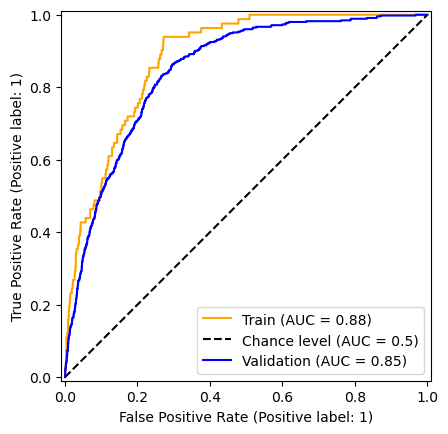

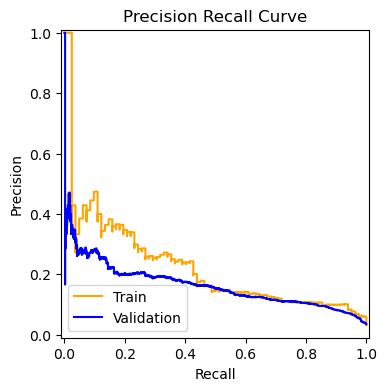

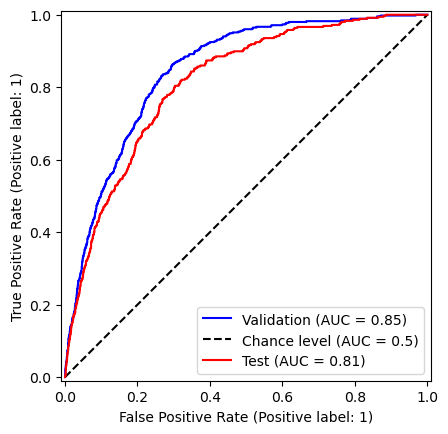

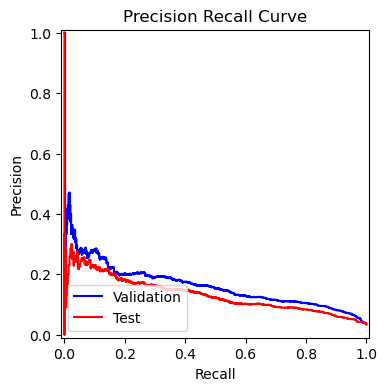

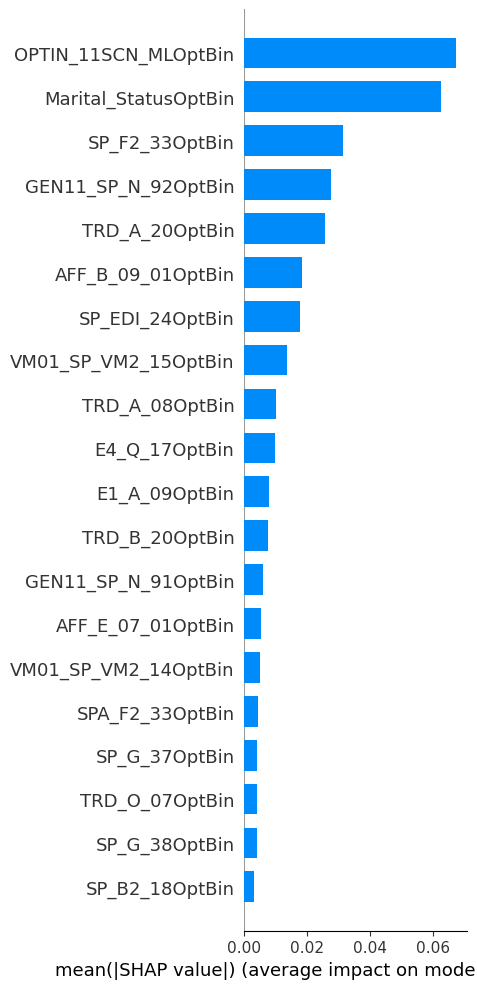

2024/05/30 13:12:28 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/05/30 13:12:28 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


In [23]:
with mlflow.start_run(run_name=RUN_NAME, log_system_metrics=True):
    res = search_hyper_params_and_log(
        run_name=RUN_NAME,
        data_dict=data_dict,
        cols_to_use=COLS_TO_USE,
        target_name=TARGET_BIN,
        distributions=PARAMS,
        n_iter=N_ITER,
        model=MODEL,
        custom_params_updates=None,
        tags={'features': len(COLS_TO_USE)}, 
        palette=PALETTE['DataPart'],
        test_name='df_test_same',
        model_path=MODELS_PATH,
        model_type='RF',
        normalize=False,
        shap_explainer=shap.TreeExplainer
    )

In [29]:
df_metrics, df_imp, data_dict, model_obj, std_scaler = res

### RF's quality

#### Feature importance, SHAP

In [30]:
df_imp.sort_values('Importance(SHAP)', ascending=False)

,Feature,Importance(SHAP),"Importance(SHAP, %)"
0,OPTIN_11SCN_MLOptBin,0.067388,18.472606
2,Marital_StatusOptBin,0.062496,17.131832
3,SP_F2_33OptBin,0.031507,8.636950
8,GEN11_SP_N_92OptBin,0.027516,7.542879
5,TRD_A_20OptBin,0.025694,7.043467
4,AFF_B_09_01OptBin,0.018327,5.023938
9,SP_EDI_24OptBin,0.017683,4.847339
7,VM01_SP_VM2_15OptBin,0.013575,3.721316
6,TRD_A_08OptBin,0.010204,2.797127
11,E4_Q_17OptBin,0.009737,2.669078


In [31]:
# features with 0 importance
df_imp[df_imp['Importance(SHAP)'] == 0]

,Feature,Importance(SHAP),"Importance(SHAP, %)"


In [32]:
# features with low importance
df_imp[df_imp['Importance(SHAP, %)'] < 1]

,Feature,Importance(SHAP),"Importance(SHAP, %)"
1,G5_ND_SPECIIOptBin,0.002386,0.653974
12,TRD_C_07OptBin,0.000794,0.217599
14,SP_B2_18OptBin,0.003089,0.846875
17,VM01_SP_VM2_24OptBin,0.002109,0.578196
19,TRD_O_05OptBin,0.001852,0.507574
22,ND_INC_03OptBin,0.001751,0.479878
23,VM01_SP_VM2_17OptBin,0.001004,0.275341
24,SP_B1_14OptBin,0.000693,0.190040
26,GEN11_SP_EDI_07OptBin,0.000682,0.186875
27,ND_ECC_06OptBin,0.002618,0.717688


In [33]:
# features with 0 importance
for col in COLS_TO_USE:
    if col not in df_imp[df_imp['Importance(SHAP)'] == 0].Feature.values:
        print(f'"{col}",')

"OPTIN_11SCN_MLOptBin",
"G5_ND_SPECIIOptBin",
"Marital_StatusOptBin",
"SP_F2_33OptBin",
"AFF_B_09_01OptBin",
"TRD_A_20OptBin",
"TRD_A_08OptBin",
"VM01_SP_VM2_15OptBin",
"GEN11_SP_N_92OptBin",
"SP_EDI_24OptBin",
"SP_G_37OptBin",
"E4_Q_17OptBin",
"TRD_C_07OptBin",
"TRD_B_20OptBin",
"SP_B2_18OptBin",
"SPA_F2_33OptBin",
"VM01_SP_VM2_14OptBin",
"VM01_SP_VM2_24OptBin",
"SP_G_38OptBin",
"TRD_O_05OptBin",
"E1_A_09OptBin",
"TRD_O_07OptBin",
"ND_INC_03OptBin",
"VM01_SP_VM2_17OptBin",
"SP_B1_14OptBin",
"GEN11_SP_N_91OptBin",
"GEN11_SP_EDI_07OptBin",
"ND_ECC_06OptBin",
"TRD_B_18OptBin",
"EA5_S_01OptBin",
"SP_I_67_01OptBin",
"SP_I_63_01OptBin",
"SP_B2_20OptBin",
"E4_Q_04OptBin",
"ND_ECC_04OptBin",
"VAL_DELINQ_ACCSOptBin",
"EA1_D_02OptBin",
"AFF_E_07_01OptBin",
"TRD_O_06OptBin",
"AFF_T_07_01OptBin",


#### GINI, AU PRC

##### Test-same

In [35]:
evaluate_model(
    data=data_dict['df_test_same'], 
    cols_to_use=COLS_TO_USE,
    std_scaler=std_scaler,
    target_name=TARGET_BIN,
    model_obj=model_obj
)

Test-PR_AUC 0.13164864891068523
Test-Gini 0.6249520216249764


##### Test-full

In [36]:
evaluate_model(
    data=data_dict['df_test'], 
    cols_to_use=COLS_TO_USE,
    std_scaler=std_scaler,
    target_name=TARGET_BIN,
    model_obj=model_obj
)

Test-PR_AUC 0.1157254834132657
Test-Gini 0.6089061344307398


#### Outcomes distributions

In [38]:
data_dict['df_test']['score'] = model_obj.predict_proba(
    data_dict['df_test'][COLS_TO_USE]
)[:, 1]

##### Test-same

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


<Axes: xlabel='score', ylabel='Density'>

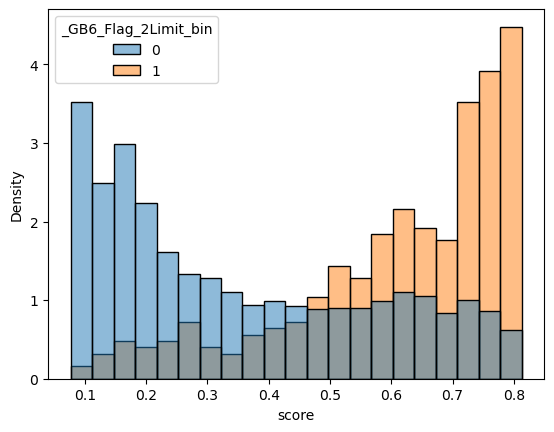

In [39]:
sns.histplot(x=data_dict['df_test_same']['score'], hue=data_dict['df_test_same'][TARGET_BIN], common_norm=False, stat='density')

##### Test-full

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


<Axes: xlabel='score', ylabel='Density'>

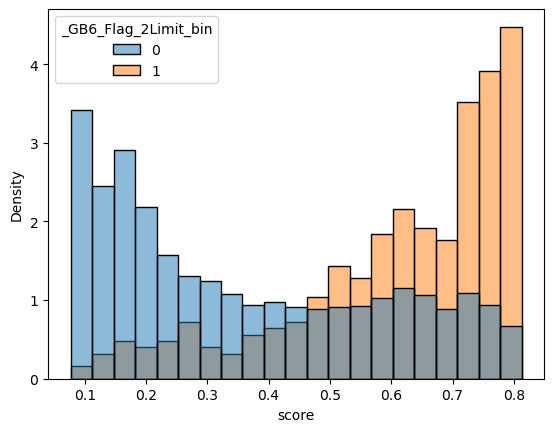

In [40]:
sns.histplot(x=data_dict['df_test']['score'], hue=data_dict['df_test'][TARGET_BIN], common_norm=False, stat='density')

#### Precision, Recall By Quantile

##### Test-same

In [41]:
m = MetricsByQuantile(metrics=["quantiles_analytics"])
r = m.compute(
    y_true=data_dict['df_test_same'][TARGET_BIN].reset_index(drop=True), 
    y_pred=data_dict['df_test_same']['score'].round(3).reset_index(drop=True), 
    list_of_metrics = [
        "cum_precision_by_quantile", "cum_recall_by_quantile", 
        "precision_by_quantile", "recall_by_quantile",
    ], 
    n_quantiles = 200
)
df_deciles = r["other"]["quantiles_analytics"]
df_deciles.head(50)

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,% of total population,Cumulative % of total population,Total,Bad,Cumulative Bad,Quantile,#Quantile,Cumulative Precision,Cumulative Recall,Precision,Recall,Scores
0,0.43,0.43,46,11,11,"(0.807, 0.813]",198,23.913043,3.081232,23.913043,3.081232,0.807--0.813
1,0.52,0.95,55,13,24,"(0.8, 0.807]",197,23.762376,6.722689,23.636364,3.641457,0.8--0.807
2,0.55,1.50,59,13,37,"(0.792, 0.8]",196,23.125000,10.364146,22.033898,3.641457,0.792--0.8
3,0.43,1.93,46,7,44,"(0.787, 0.792]",195,21.359223,12.324930,15.217391,1.960784,0.787--0.792
4,0.56,2.50,60,10,54,"(0.779, 0.787]",194,20.300752,15.126050,16.666667,2.801120,0.779--0.787
5,0.44,2.94,47,7,61,"(0.772, 0.779]",193,19.488818,17.086835,14.893617,1.960784,0.772--0.779
6,0.54,3.48,57,7,68,"(0.765, 0.772]",192,18.378378,19.047619,12.280702,1.960784,0.765--0.772
7,0.53,4.00,56,8,76,"(0.759, 0.765]",191,17.840376,21.288515,14.285714,2.240896,0.759--0.765
8,0.44,4.44,47,5,81,"(0.756, 0.759]",190,17.124736,22.689076,10.638298,1.400560,0.756--0.759
9,0.53,4.97,56,10,91,"(0.751, 0.756]",189,17.202268,25.490196,17.857143,2.801120,0.751--0.756


##### Test-full

In [42]:
m = MetricsByQuantile(metrics=["quantiles_analytics"])
r = m.compute(
    y_true=data_dict['df_test'][TARGET_BIN].reset_index(drop=True), 
    y_pred=data_dict['df_test']['score'].round(3).reset_index(drop=True), 
    list_of_metrics = [
        "cum_precision_by_quantile", "cum_recall_by_quantile", 
        "precision_by_quantile", "recall_by_quantile",
    ], 
    n_quantiles = 200
)
df_deciles = r["other"]["quantiles_analytics"]
df_deciles.head(50)

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,% of total population,Cumulative % of total population,Total,Bad,Cumulative Bad,Quantile,#Quantile,Cumulative Precision,Cumulative Recall,Precision,Recall,Scores
0,0.27,0.27,30,2,2,"(0.808, 0.813]",199,6.666667,0.560224,6.666667,0.560224,0.808--0.813
1,0.73,0.99,82,22,24,"(0.801, 0.808]",198,21.428571,6.722689,26.829268,6.162465,0.801--0.808
2,0.46,1.45,52,9,33,"(0.795, 0.801]",197,20.121951,9.243697,17.307692,2.521008,0.795--0.801
3,0.53,1.98,60,9,42,"(0.788, 0.795]",196,18.750000,11.764706,15.000000,2.521008,0.788--0.795
4,0.50,2.48,56,11,53,"(0.781, 0.788]",195,18.928571,14.845938,19.642857,3.081232,0.781--0.788
5,0.49,2.97,55,7,60,"(0.774, 0.781]",194,17.910448,16.806723,12.727273,1.960784,0.774--0.781
6,0.44,3.41,50,3,63,"(0.768, 0.774]",193,16.363636,17.647059,6.000000,0.840336,0.768--0.774
7,0.58,3.99,66,9,72,"(0.761, 0.768]",192,15.964523,20.168067,13.636364,2.521008,0.761--0.768
8,0.38,4.37,43,5,77,"(0.758, 0.761]",191,15.587045,21.568627,11.627907,1.400560,0.758--0.761
9,0.59,4.97,67,8,85,"(0.754, 0.758]",190,15.151515,23.809524,11.940299,2.240896,0.754--0.758


## LR

### Train model

In [43]:
MODEL = LogisticRegression

In [46]:
PARAMS = dict(
    penalty=['l2', 'l1', 'elasticnet'], 
    C=uniform(loc=0, scale=20), 
    fit_intercept=[True], 
    class_weight=['balanced'], 
    random_state=[RANDOM_SEED], 
    n_jobs=[-1]
)

In [47]:
RUN_NAME = '04-LR-hyperparams_tunning'

2024/05/30 13:24:33 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:24:33 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 1 / 100
# 2 / 100


2024/05/30 13:24:33 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:24:33 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 3 / 100
# 4 / 100


2024/05/30 13:24:42 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:24:42 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 5 / 100
# 6 / 100
# 7 / 100


2024/05/30 13:24:49 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:24:49 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 8 / 100


2024/05/30 13:24:55 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:24:55 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 9 / 100


2024/05/30 13:25:02 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:25:02 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 10 / 100
# 11 / 100
# 12 / 100


2024/05/30 13:25:10 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:25:10 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 13 / 100
# 14 / 100


2024/05/30 13:25:17 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:25:17 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 15 / 100


2024/05/30 13:25:23 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:25:23 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 16 / 100


2024/05/30 13:25:30 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:25:30 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 17 / 100
# 18 / 100
# 19 / 100
# 20 / 100


2024/05/30 13:25:37 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:25:37 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 21 / 100
# 22 / 100
# 23 / 100
# 24 / 100
# 25 / 100


2024/05/30 13:25:45 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:25:45 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 26 / 100
# 27 / 100
# 28 / 100


2024/05/30 13:25:53 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:25:53 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 29 / 100


2024/05/30 13:26:02 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:26:02 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 30 / 100
# 31 / 100


2024/05/30 13:26:09 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:26:09 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 32 / 100
# 33 / 100


2024/05/30 13:26:15 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 13:26:15 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 34 / 100
# 35 / 100
# 36 / 100
# 37 / 100
# 38 / 100
# 39 / 100
# 40 / 100


2024/05/30 13:26:24 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:26:24 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 41 / 100
# 42 / 100
# 43 / 100
# 44 / 100
# 45 / 100
# 46 / 100
# 47 / 100


2024/05/30 13:26:34 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:26:34 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 48 / 100
# 49 / 100


2024/05/30 13:26:41 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:26:41 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 50 / 100
# 51 / 100
# 52 / 100
# 53 / 100
# 54 / 100
# 55 / 100
# 56 / 100
# 57 / 100


2024/05/30 13:26:51 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 13:26:51 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 58 / 100


2024/05/30 13:26:58 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/30 13:26:58 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 59 / 100


2024/05/30 13:27:06 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:27:06 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 60 / 100
# 61 / 100
# 62 / 100
# 63 / 100
# 64 / 100
# 65 / 100
# 66 / 100
# 67 / 100


2024/05/30 13:27:14 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:27:14 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 68 / 100
# 69 / 100
# 70 / 100
# 71 / 100
# 72 / 100


2024/05/30 13:27:22 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:27:22 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 73 / 100


2024/05/30 13:27:31 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:27:31 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 74 / 100
# 75 / 100
# 76 / 100
# 77 / 100
# 78 / 100


2024/05/30 13:27:40 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:27:40 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 79 / 100
# 80 / 100
# 81 / 100


2024/05/30 13:27:49 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:27:49 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 82 / 100
# 83 / 100
# 84 / 100
# 85 / 100
# 86 / 100
# 87 / 100


2024/05/30 13:27:58 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:27:58 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 88 / 100


2024/05/30 13:28:06 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:28:06 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 89 / 100
# 90 / 100
# 91 / 100
# 92 / 100


2024/05/30 13:28:14 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:28:14 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 93 / 100
# 94 / 100
# 95 / 100


2024/05/30 13:28:21 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:28:21 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 96 / 100
# 97 / 100


2024/05/30 13:28:28 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:28:28 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 98 / 100


2024/05/30 13:28:35 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:28:35 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 99 / 100


2024/05/30 13:28:42 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:28:42 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 100 / 100


2024/05/30 13:28:49 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/30 13:28:49 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

Best params:
 {'penalty': 'l1', 'C': 0.14132610439434812, 'fit_intercept': True, 'class_weight': 'balanced', 'random_state': 42, 'n_jobs': -1, 'solver': 'liblinear'}
Val-PR_AUC:  0.14265248224452864
Val-GINI:  0.6657522939590421


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.


Not saved
Test-PR_AUC 0.13788252989960542
Test-Gini 0.6642744172498931


The option feature_dependence has been renamed to feature_perturbation!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


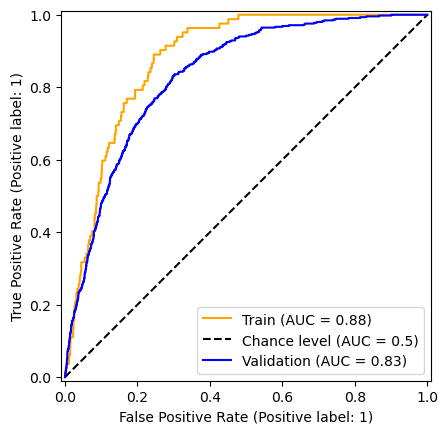

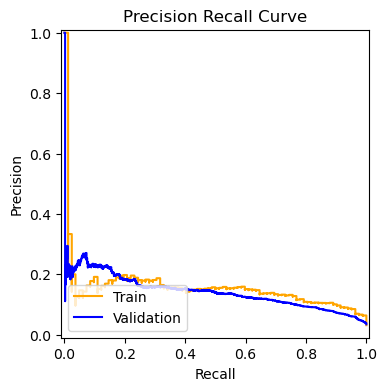

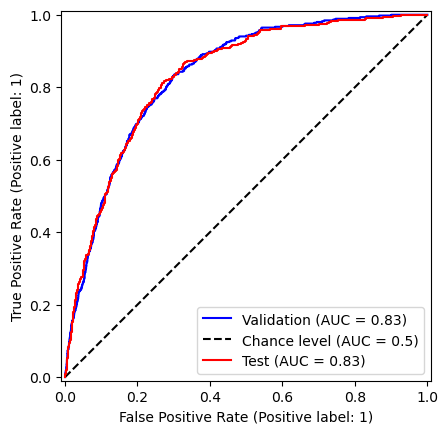

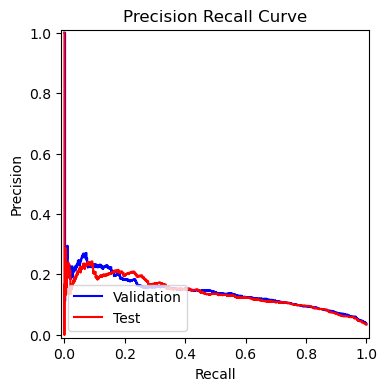

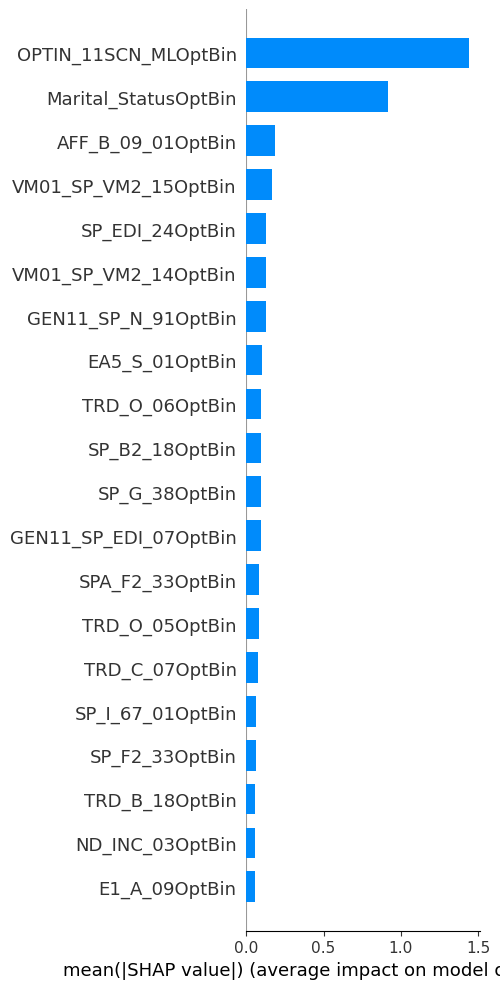

2024/05/30 13:29:18 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/05/30 13:29:18 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


In [51]:
with mlflow.start_run(run_name=RUN_NAME, log_system_metrics=True):
    res = search_hyper_params_and_log(
        run_name=RUN_NAME,
        data_dict=data_dict,
        cols_to_use=COLS_TO_USE,
        target_name=TARGET_BIN,
        distributions=PARAMS,
        n_iter=N_ITER,
        model=MODEL,
        custom_params_updates=update_solver_by_penalty,
        tags={'features': len(COLS_TO_USE)}, 
        palette=PALETTE['DataPart'],
        test_name='df_test_same',
        model_path=MODELS_PATH,
        model_type='lr',
        normalize=True
    )

In [52]:
df_metrics, df_coeff, data_dict, model_obj, std_scaler = res

### Model's quality

#### Feature importance, coeff

In [53]:
df_coeff.sort_values('Importance(%)', ascending=False)

,Feature,Coeff,Importance(%),p-value,Importance(SHAP),"Importance(SHAP, %)"
12,Intercept,-1.420114,20.204932,0.000000e+00,NaN,NaN
17,OPTIN_11SCN_MLOptBin,-1.113546,15.843186,0.000000e+00,1.440580,31.560403
13,Marital_StatusOptBin,-0.743957,10.584788,0.000000e+00,0.913732,20.018141
7,EA5_S_01OptBin,-0.217432,3.093554,2.220446e-16,0.101791,2.230045
33,TRD_O_05OptBin,-0.211689,3.011844,2.866596e-12,0.078639,1.722822
10,GEN11_SP_N_91OptBin,-0.208968,2.973138,4.331087e-08,0.125220,2.743339
22,SP_EDI_24OptBin,-0.205660,2.926068,8.828108e-06,0.128922,2.824438
9,GEN11_SP_EDI_07OptBin,0.185131,2.633980,1.191706e-06,0.091890,2.013129
34,TRD_O_06OptBin,0.184874,2.630335,3.729748e-10,0.094692,2.074520
0,AFF_B_09_01OptBin,0.182773,2.600431,4.108037e-04,0.182832,4.005498


In [54]:
# features with 0 importance
df_coeff[df_coeff['Coeff'] == 0]

,Feature,Coeff,Importance(%),p-value,Importance(SHAP),"Importance(SHAP, %)"
21,SP_B2_20OptBin,0.0,0.0,1.0,0.0,0.0


In [57]:
# features with low importance
df_coeff[df_coeff['p-value'] > CONFIDENCE_LEVEL]

,Feature,Coeff,Importance(%),p-value,Importance(SHAP),"Importance(SHAP, %)"
2,AFF_T_07_01OptBin,-0.048506,0.690128,0.077160,0.014322,0.313777
4,E4_Q_04OptBin,-0.011422,0.162513,0.682916,0.004410,0.096614
5,E4_Q_17OptBin,0.051400,0.731306,0.098786,0.035069,0.768289
6,EA1_D_02OptBin,-0.022866,0.325326,0.311352,0.004884,0.106997
11,GEN11_SP_N_92OptBin,0.017179,0.244421,0.638598,0.013381,0.293161
15,ND_ECC_06OptBin,0.085572,1.217494,0.056275,0.049088,1.075417
19,SP_B1_14OptBin,0.018334,0.260844,0.698259,0.008618,0.188810
21,SP_B2_20OptBin,0.000000,0.000000,1.000000,0.000000,0.000000
23,SP_F2_33OptBin,0.055273,0.786410,0.246123,0.058754,1.287188
24,SP_G_37OptBin,0.057536,0.818602,0.118359,0.042304,0.926800


In [58]:
# features with p-values low than the confident level
for col in COLS_TO_USE:
    if col not in df_coeff[df_coeff['p-value'] > CONFIDENCE_LEVEL].Feature.values:
        print(f'"{col}",')

"OPTIN_11SCN_MLOptBin",
"G5_ND_SPECIIOptBin",
"Marital_StatusOptBin",
"AFF_B_09_01OptBin",
"VM01_SP_VM2_15OptBin",
"SP_EDI_24OptBin",
"TRD_C_07OptBin",
"SP_B2_18OptBin",
"SPA_F2_33OptBin",
"VM01_SP_VM2_14OptBin",
"SP_G_38OptBin",
"TRD_O_05OptBin",
"E1_A_09OptBin",
"TRD_O_07OptBin",
"ND_INC_03OptBin",
"GEN11_SP_N_91OptBin",
"GEN11_SP_EDI_07OptBin",
"TRD_B_18OptBin",
"EA5_S_01OptBin",
"SP_I_67_01OptBin",
"ND_ECC_04OptBin",
"AFF_E_07_01OptBin",
"TRD_O_06OptBin",


In [62]:
rf_unimp = df_imp[df_imp['Importance(SHAP, %)'] < 1].Feature.values
print('# features with < 1% importance based on SHAP, RF: ', len(rf_unimp))

# features with < 1% importance based on SHAP, RF:  21


In [63]:
lr_unimp = df_coeff[df_coeff['p-value'] > CONFIDENCE_LEVEL].Feature.values
print(f'# features with p-value > {CONFIDENCE_LEVEL}, LR: ', len(lr_unimp))

# features with p-value > 0.05, LR:  17


In [64]:
inter_unimp = set(rf_unimp).intersection(set(lr_unimp))
print('# intersected features: ', len(inter_unimp))
print(inter_unimp)

# intersected features:  10
{'VAL_DELINQ_ACCSOptBin', 'SP_I_63_01OptBin', 'AFF_T_07_01OptBin', 'ND_ECC_06OptBin', 'SP_B1_14OptBin', 'EA1_D_02OptBin', 'VM01_SP_VM2_17OptBin', 'E4_Q_04OptBin', 'VM01_SP_VM2_24OptBin', 'SP_B2_20OptBin'}


In [66]:
for col in COLS_TO_USE:
    if col not in inter_unimp:
        print(f'"{col}",')

"OPTIN_11SCN_MLOptBin",
"G5_ND_SPECIIOptBin",
"Marital_StatusOptBin",
"SP_F2_33OptBin",
"AFF_B_09_01OptBin",
"TRD_A_20OptBin",
"TRD_A_08OptBin",
"VM01_SP_VM2_15OptBin",
"GEN11_SP_N_92OptBin",
"SP_EDI_24OptBin",
"SP_G_37OptBin",
"E4_Q_17OptBin",
"TRD_C_07OptBin",
"TRD_B_20OptBin",
"SP_B2_18OptBin",
"SPA_F2_33OptBin",
"VM01_SP_VM2_14OptBin",
"SP_G_38OptBin",
"TRD_O_05OptBin",
"E1_A_09OptBin",
"TRD_O_07OptBin",
"ND_INC_03OptBin",
"GEN11_SP_N_91OptBin",
"GEN11_SP_EDI_07OptBin",
"TRD_B_18OptBin",
"EA5_S_01OptBin",
"SP_I_67_01OptBin",
"ND_ECC_04OptBin",
"AFF_E_07_01OptBin",
"TRD_O_06OptBin",


#### GINI, AU PRC

##### Test-same

In [29]:
evaluate_model(
    data=data_dict['df_test_same'], 
    cols_to_use=COLS_TO_USE,
    std_scaler=std_scaler,
    target_name=TARGET_BIN,
    model_obj=model_obj
)

Test-PR_AUC 0.13532003243288082
Test-Gini 0.6609206948085358


##### Test-full

In [30]:
evaluate_model(
    data=data_dict['df_test'], 
    cols_to_use=COLS_TO_USE,
    std_scaler=std_scaler,
    target_name=TARGET_BIN,
    model_obj=model_obj
)

Test-PR_AUC 0.11736838701922538
Test-Gini 0.6422205478480578


#### Outcomes distributions

In [31]:
data_dict['df_test']['score'] = model_obj.predict_proba(
    std_scaler.transform(data_dict['df_test'][COLS_TO_USE])
)[:, 1]

##### Test-same

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


<Axes: xlabel='score', ylabel='Density'>

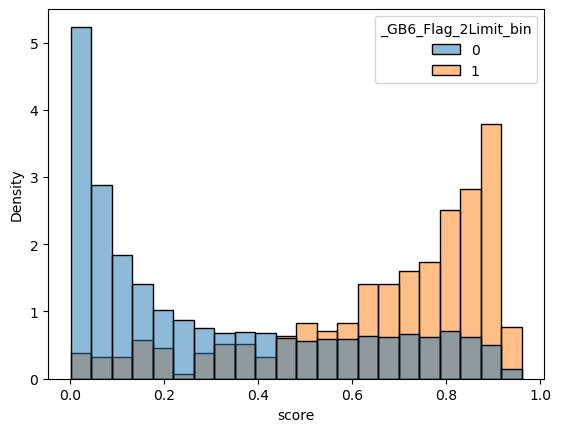

In [32]:
sns.histplot(x=data_dict['df_test_same']['score'], hue=data_dict['df_test_same'][TARGET_BIN], common_norm=False, stat='density')

##### Test-full

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


<Axes: xlabel='score', ylabel='Density'>

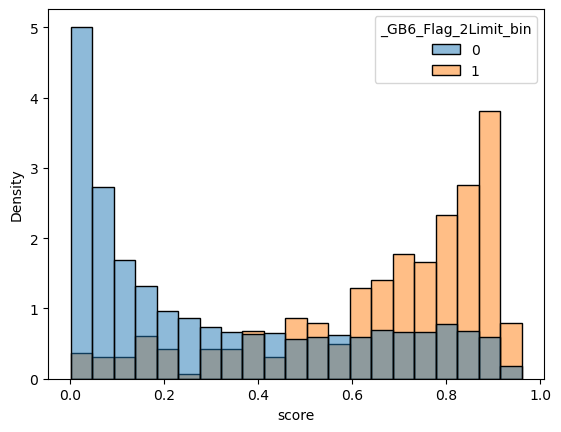

In [33]:
sns.histplot(x=data_dict['df_test']['score'], hue=data_dict['df_test'][TARGET_BIN], common_norm=False, stat='density')

#### Precision, Recall By Quantile

##### Test-same

In [34]:
m = MetricsByQuantile(metrics=["quantiles_analytics"])
r = m.compute(
    y_true=data_dict['df_test_same'][TARGET_BIN].reset_index(drop=True), 
    y_pred=data_dict['df_test_same']['score'].round(3).reset_index(drop=True), 
    list_of_metrics = [
        "cum_precision_by_quantile", "cum_recall_by_quantile", 
        "precision_by_quantile", "recall_by_quantile",
    ], 
    n_quantiles = 200
)
df_deciles = r["other"]["quantiles_analytics"]
df_deciles.head(50)

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,% of total population,Cumulative % of total population,Total,Bad,Cumulative Bad,Quantile,#Quantile,Cumulative Precision,Cumulative Recall,Precision,Recall,Scores
0,0.49,0.49,52,10,10,"(0.923, 0.961]",193,19.230769,2.801120,19.230769,2.801120,0.923--0.961
1,0.50,0.99,53,7,17,"(0.911, 0.923]",192,16.190476,4.761905,13.207547,1.960784,0.911--0.923
2,0.52,1.50,55,14,31,"(0.904, 0.911]",191,19.375000,8.683473,25.454545,3.921569,0.904--0.911
3,0.49,1.99,52,11,42,"(0.895, 0.904]",190,19.811321,11.764706,21.153846,3.081232,0.895--0.904
4,0.51,2.50,54,11,53,"(0.886, 0.895]",189,19.924812,14.845938,20.370370,3.081232,0.886--0.895
5,0.50,3.00,53,10,63,"(0.88, 0.886]",188,19.749216,17.647059,18.867925,2.801120,0.88--0.886
6,0.51,3.50,54,10,73,"(0.872, 0.88]",187,19.571046,20.448179,18.518519,2.801120,0.872--0.88
7,0.48,3.98,51,10,83,"(0.864, 0.872]",186,19.575472,23.249300,19.607843,2.801120,0.864--0.872
8,0.47,4.45,50,7,90,"(0.857, 0.864]",185,18.987342,25.210084,14.000000,1.960784,0.857--0.864
9,0.55,5.01,59,10,100,"(0.85, 0.857]",184,18.761726,28.011204,16.949153,2.801120,0.85--0.857


##### Test-full

In [35]:
m = MetricsByQuantile(metrics=["quantiles_analytics"])
r = m.compute(
    y_true=data_dict['df_test'][TARGET_BIN].reset_index(drop=True), 
    y_pred=data_dict['df_test']['score'].round(3).reset_index(drop=True), 
    list_of_metrics = [
        "cum_precision_by_quantile", "cum_recall_by_quantile", 
        "precision_by_quantile", "recall_by_quantile",
    ], 
    n_quantiles = 200
)
df_deciles = r["other"]["quantiles_analytics"]
df_deciles.head(50)

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,% of total population,Cumulative % of total population,Total,Bad,Cumulative Bad,Quantile,#Quantile,Cumulative Precision,Cumulative Recall,Precision,Recall,Scores
0,0.45,0.45,51,10,10,"(0.926, 0.961]",193,19.607843,2.801120,19.607843,2.801120,0.926--0.961
1,0.53,0.98,60,6,16,"(0.914, 0.926]",192,14.414414,4.481793,10.000000,1.680672,0.914--0.926
2,0.48,1.46,54,12,28,"(0.907, 0.914]",191,16.969697,7.843137,22.222222,3.361345,0.907--0.914
3,0.50,1.96,57,8,36,"(0.9, 0.907]",190,16.216216,10.084034,14.035088,2.240896,0.9--0.907
4,0.53,2.50,60,10,46,"(0.89, 0.9]",189,16.312057,12.885154,16.666667,2.801120,0.89--0.9
5,0.41,2.90,46,9,55,"(0.885, 0.89]",188,16.768293,15.406162,19.565217,2.521008,0.885--0.89
6,0.59,3.50,67,13,68,"(0.877, 0.885]",187,17.215190,19.047619,19.402985,3.641457,0.877--0.885
7,0.48,3.97,54,6,74,"(0.87, 0.877]",186,16.481069,20.728291,11.111111,1.680672,0.87--0.877
8,0.49,4.46,55,9,83,"(0.863, 0.87]",185,16.468254,23.249300,16.363636,2.521008,0.863--0.87
9,0.52,4.98,59,7,90,"(0.856, 0.863]",184,15.985790,25.210084,11.864407,1.960784,0.856--0.863
